In [3]:
import os, sys, random
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from  tensorflow import keras
from tqdm import tqdm
from REDInet import Utils

def give_inputs(cell_line):
    
    if cell_line == "HEK293T":  
        samples = [["outTable_599710609", "outTable_905657585"],
                   ["outTable_572868058", "outTable_364841872"],
                   ["outTable_110067244", "outTable_597789462"]]

    elif cell_line == "HEK":
        samples = [["outTable_724242056", "outTable_816573740"],
                   ["outTable_580067564", "outTable_718392497"],
                   ["outTable_181728208", "outTable_854894021"]]

    else:
        samples = [["outTable_192318299", "outTable_436061877"],
                   ["outTable_535670354", "outTable_396704193"],
                   ["outTable_773331943", "outTable_302610513"]]
   
    filespath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/{}".format(cells)
    return samples, filespath


def make_imputations(cells, model_filepath):
    
    tables, tables_filespath =  give_inputs(cells)
    
    cols =  ["Region", "Position", "Strand"]
    
    if cells == "HEK293T":
        prefix = "HEK(hg38)"
        suffix_1 = "WT-KO"
        suffix_2 = "OVE-KO"
    elif cells == "a549":
        prefix = cells
        suffix_1 = "WT-SI"
    else:
        prefix = "HEK(hg19)"
        suffix_1 = "WT-KO"

    left = list(range(0, int((101-1)/2)))
    right = list(range(int((101-1)/2)+1, 101))
                    
    model = tf.keras.models.load_model(model_filepath)         
    imputations_filespath = os.path.join(tables_filespath, f"{cells}_imputations")
    if not os.path.isdir(imputations_filespath):
        os.mkdir(imputations_filespath)
        
    imputation_table_results = []
                    
    for imp in range(0, 51): 
        imputations_positions_tot = []
        
        y_true = []
        y_pred = []
        
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        
        for i in tqdm(range(3)):
            
            imputations_positions = []
            
            wt = pd.read_table(f"{tables_filespath}/{tables[i][0]}_intervals.tsv", sep="\t", usecols=cols)
            X = pd.read_table(f"{tables_filespath}/{tables[i][0]}_feature_vectors.tsv", header=None, sep="\t")
            X_3d = Utils().from_2_to_3_dimensions(X, 8)
            

            for y in range(X_3d.shape[0]): 
                temp = []
                positions = random.sample(left, k=imp) + random.sample(right, k=imp)
                for z in positions:  
                    temp.append(z)
                    X_3d[y, z, 4:8] = X_3d[y, z, 0:4]
                imputations_positions += temp
            
            X_3d_log2 = Utils().log_preprocessing(X_3d)
            y_hat_proba = model.predict(X_3d_log2, batch_size=512, verbose=0)
            wt.loc[:, "Editing_Probability"] = y_hat_proba
            
            adars_inactive = pd.read_table(f"{tables_filespath}/{tables[i][1]}_intervals.tsv", sep="\t", usecols=cols)
            X = pd.read_table(f"{tables_filespath}/{tables[i][1]}_feature_vectors.tsv", header=None, sep="\t")
            X_3d = Utils().from_2_to_3_dimensions(X, 8)
            
            for y in range(X_3d.shape[0]):
                temp = []
                positions = random.sample(left, k=imp) + random.sample(right, k=imp)
                for z in positions:  
                    temp.append(z)
                    X_3d[y, z, 4:8] = X_3d[y, z, 0:4]
                imputations_positions += temp
                
            X_3d_log2 = Utils().log_preprocessing(X_3d)
            y_hat_proba = model.predict(X_3d_log2, batch_size=512, verbose=0)
            adars_inactive.loc[:, "Editing_Probability"] = y_hat_proba
    
            imputations_positions_tot.append(imputations_positions)
            
            sites = pd.read_table(os.path.join(tables_filespath, f"{tables[i][0]}_{tables[i][1]}_bona_fide_sites.tsv"),
                                               sep="\t", usecols=["Region", "Position", "Class"])
              
            wt["index_wt"] = wt.index.tolist()
            adars_inactive["index_adars_inactive"] = adars_inactive.index.tolist()
            merged = wt.merge(adars_inactive, how ="inner", on=["Region", "Position", "Strand"])
            merged = merged.merge(sites, how="inner", on=["Region", "Position"])
            common_pos = merged[merged.loc[:, "Class"]==1]
            index_common_pos = common_pos.loc[:, "index_wt"].tolist()
            merged = merged[merged.loc[:, "Class"]==0]
            index_adars_inactive = merged["index_adars_inactive"].tolist()
            index_wt = merged["index_wt"].tolist()
            snps_adars_inactive = adars_inactive.iloc[index_adars_inactive, :]
            snps_wt = wt.iloc[index_wt, :]
            snps = pd.concat([snps_wt, snps_adars_inactive], axis=0)
            snps.drop(["index_wt", "index_adars_inactive"], axis=1, inplace=True)
            snps.reset_index(drop=True, inplace=True)
            index_drop = index_common_pos + index_wt
            index_drop.sort()
            pos = wt.drop(index_drop)
            pos.reset_index(drop=True, inplace=True)
            pos = pos.merge(sites, how="inner", on=["Region", "Position"])
            pos.reset_index(drop=True, inplace=True)

            y_true += [1 for i in range(len(pos))] + [0 for i in range(len(snps))]
            y_pred += pos.loc[:, "Editing_Probability"].tolist() + snps.loc[:, "Editing_Probability"].tolist()
            
            predictions = []
            for x in y_pred:
                if x > 0.5:
                    predictions.append(1)
                else:
                    predictions.append(0)
            
            
            for j in range(len(y_true)):
                if y_true[j] == 1:
                    if predictions[j] == 1:
                        tp += 1
                    else:
                        fn += 1
                else:
                    if predictions[j] == 1:
                        fp += 1
                    else:
                        tn += 1

        imputation_table_results.append([imp*2, tp, fp, tn, fn])
        
        Utils().make_confusion_matrix(y_true,  y_pred,
                                      title = f"{prefix} {suffix_1} Inference Confusion Matrix With {imp*2} Imputations",
                                      figsize=(6,5),
                                      path=os.path.join(imputations_filespath, f"{cells}_{suffix_1}_{imp*2}_Imputations_Inference_Conf_Matrix.tiff"))        
                
        imputations_table = pd.DataFrame(imputations_positions_tot)
        imputations_table.to_csv(os.path.join(imputations_filespath, f"{cells}_{suffix_1}_{imp*2}_Imputations_Table.tsv"), 
                                 sep="\t", header=False, index=None)       
    
    imputation_table_results = pd.DataFrame(imputation_table_results, columns=["N_Imputations", "TP", "FP", "TN", "FN"])           

    imputation_table_results.to_csv(os.path.join(imputations_filespath, "HEK293T_WT-KO_Total_Imputations_Inference_Results.tsv"),
                                   sep="\t", index=None)
    
    return imputation_table_results, imputations_filespath

100%|██████████| 3/3 [00:08<00:00,  2.72s/it]


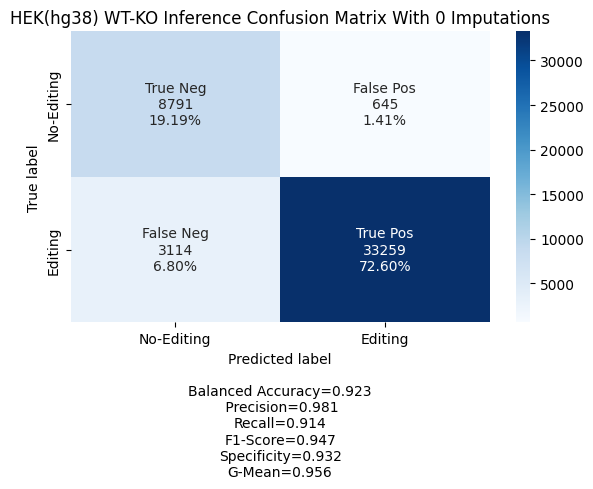

100%|██████████| 3/3 [00:06<00:00,  2.31s/it]


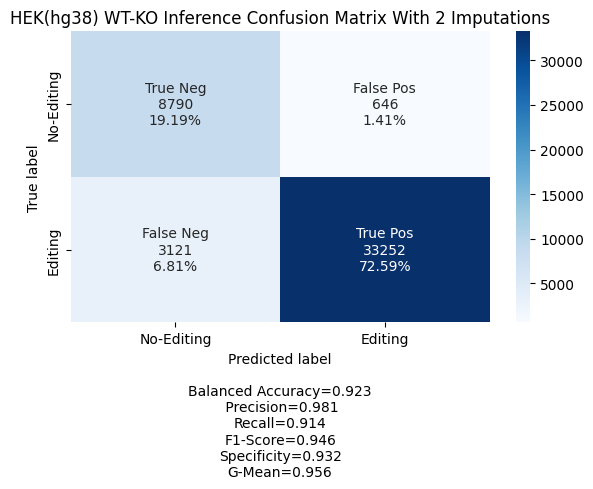

100%|██████████| 3/3 [00:07<00:00,  2.56s/it]


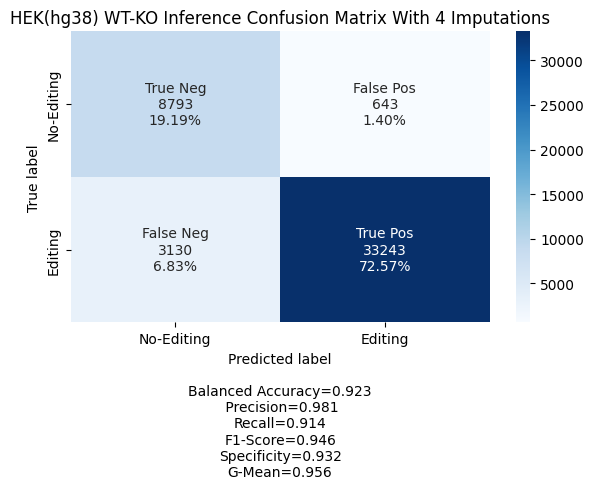

100%|██████████| 3/3 [00:07<00:00,  2.39s/it]


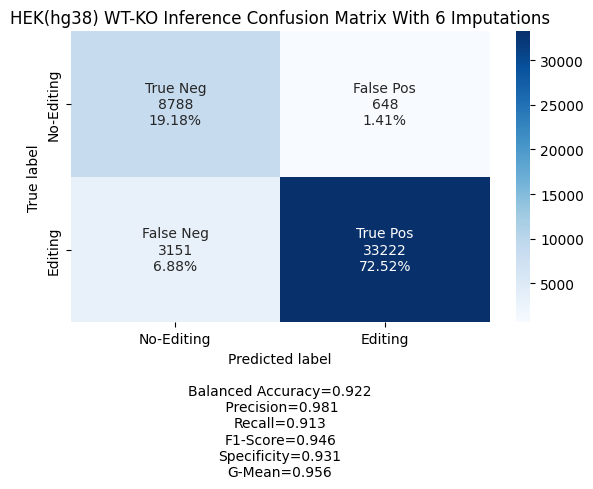

100%|██████████| 3/3 [00:07<00:00,  2.49s/it]


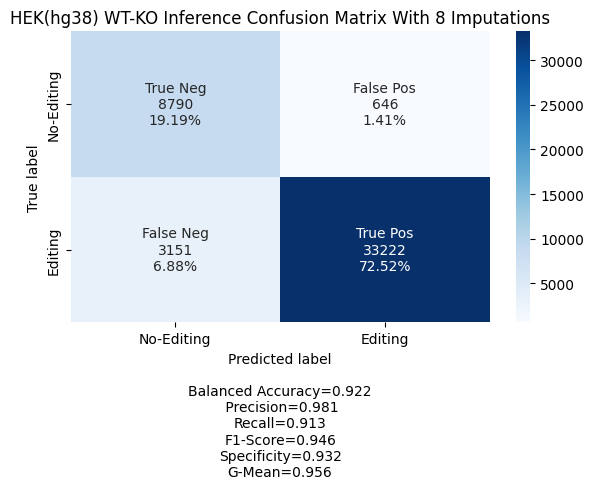

100%|██████████| 3/3 [00:07<00:00,  2.56s/it]


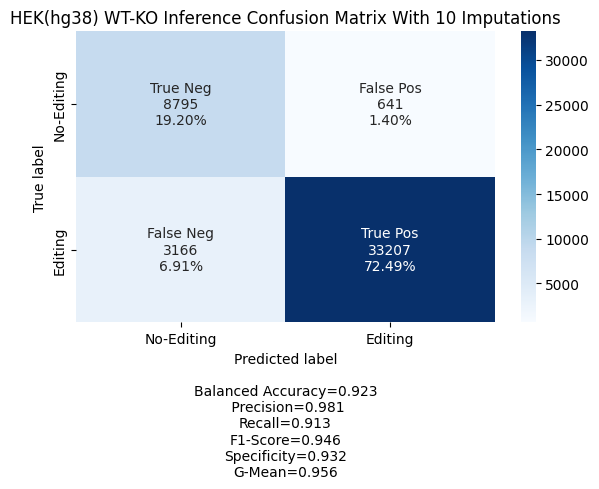

100%|██████████| 3/3 [00:07<00:00,  2.58s/it]


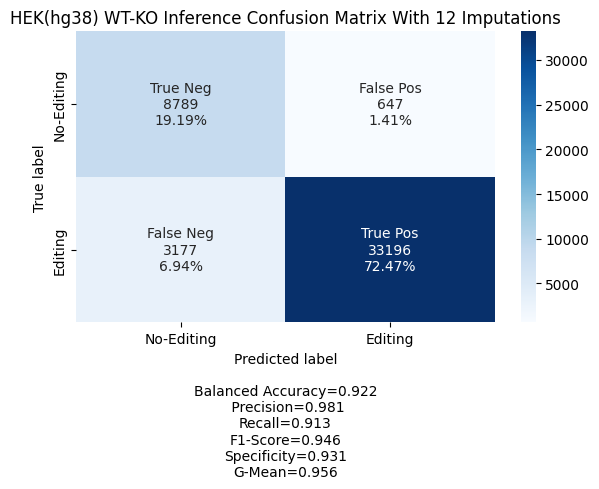

100%|██████████| 3/3 [00:08<00:00,  2.70s/it]


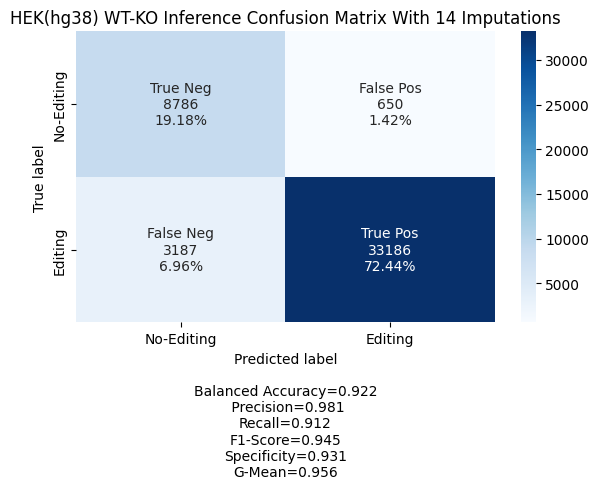

100%|██████████| 3/3 [00:08<00:00,  2.73s/it]


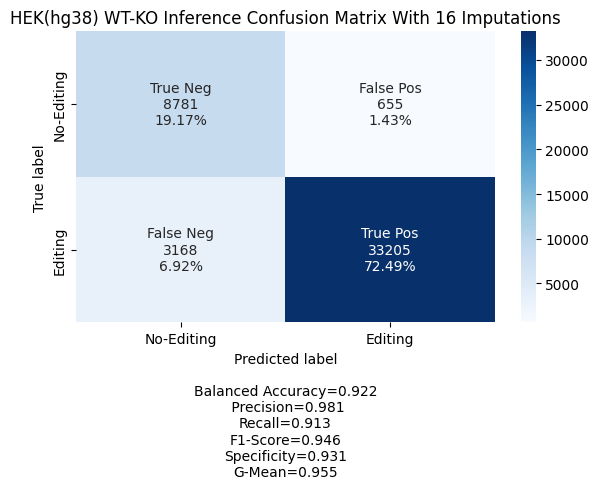

100%|██████████| 3/3 [00:08<00:00,  2.80s/it]


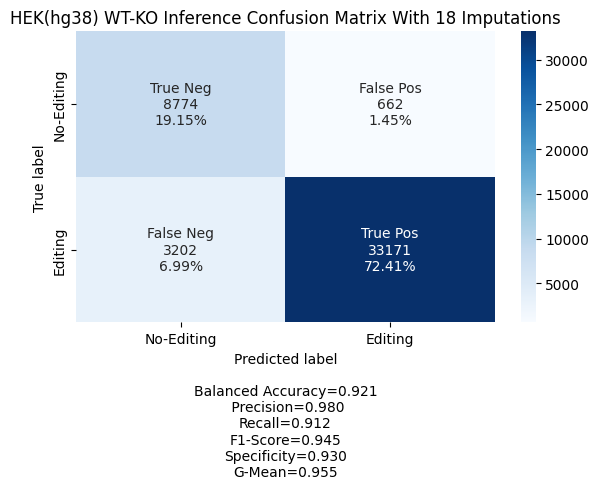

100%|██████████| 3/3 [00:08<00:00,  2.83s/it]


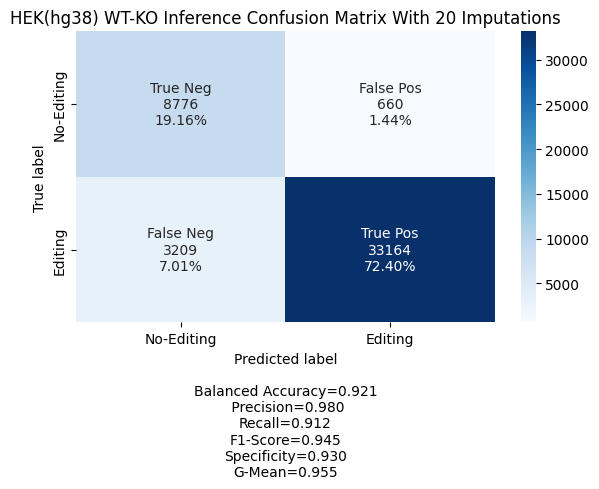

100%|██████████| 3/3 [00:08<00:00,  2.88s/it]


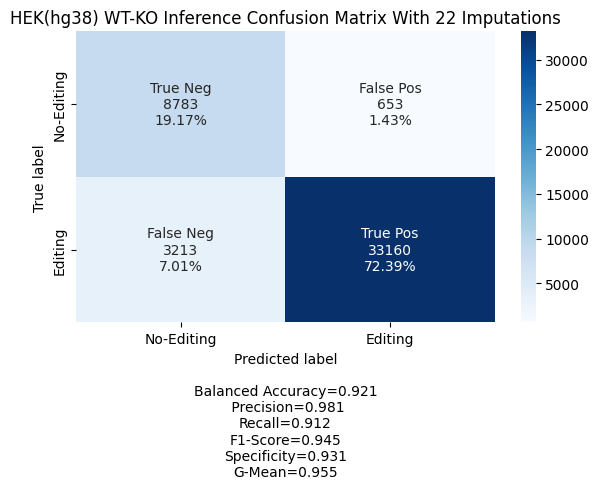

100%|██████████| 3/3 [00:08<00:00,  2.91s/it]


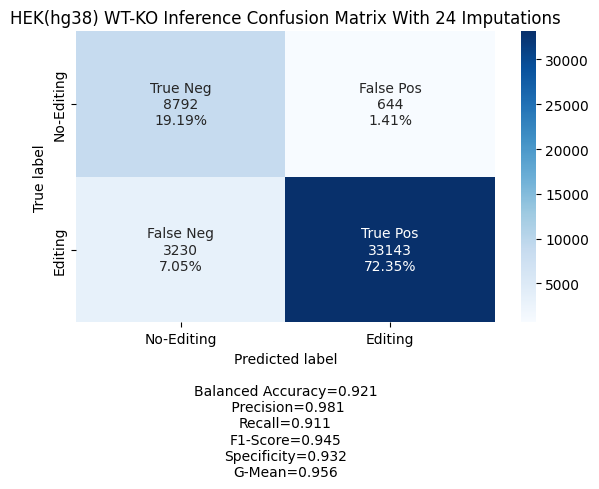

100%|██████████| 3/3 [00:08<00:00,  2.96s/it]


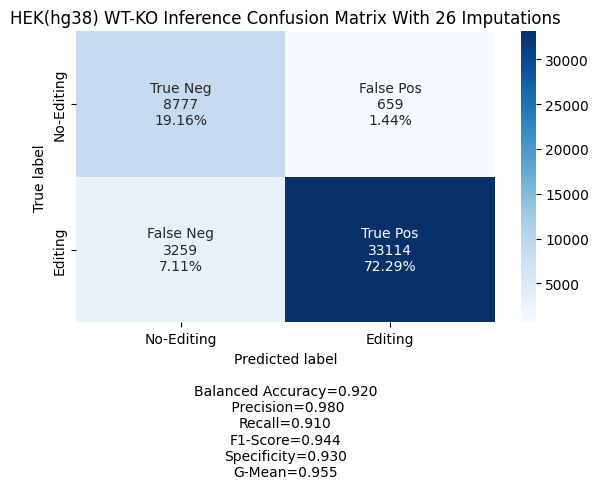

100%|██████████| 3/3 [00:08<00:00,  3.00s/it]


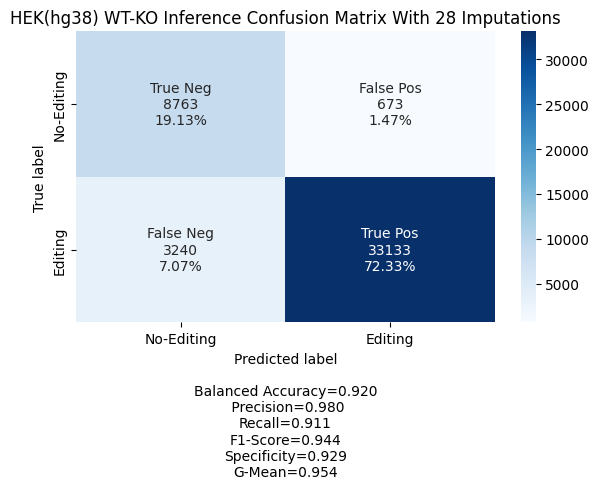

100%|██████████| 3/3 [00:09<00:00,  3.09s/it]


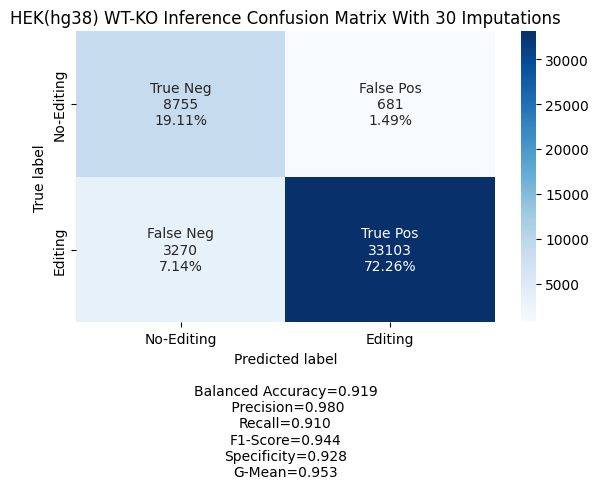

100%|██████████| 3/3 [00:09<00:00,  3.18s/it]


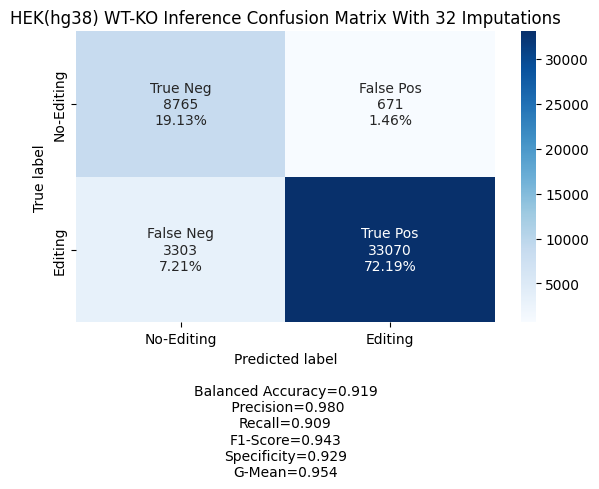

100%|██████████| 3/3 [00:09<00:00,  3.18s/it]


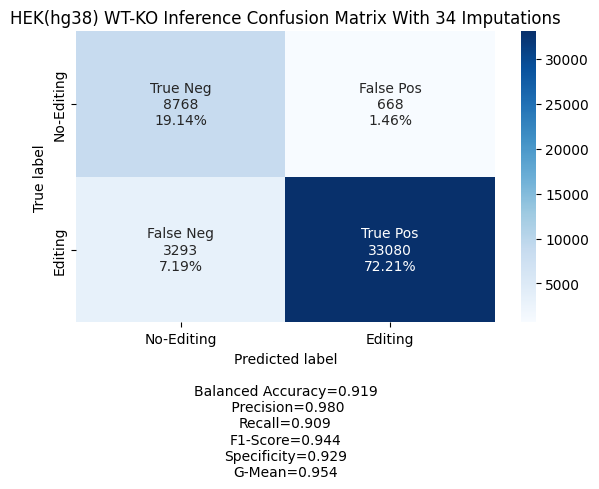

100%|██████████| 3/3 [00:09<00:00,  3.27s/it]


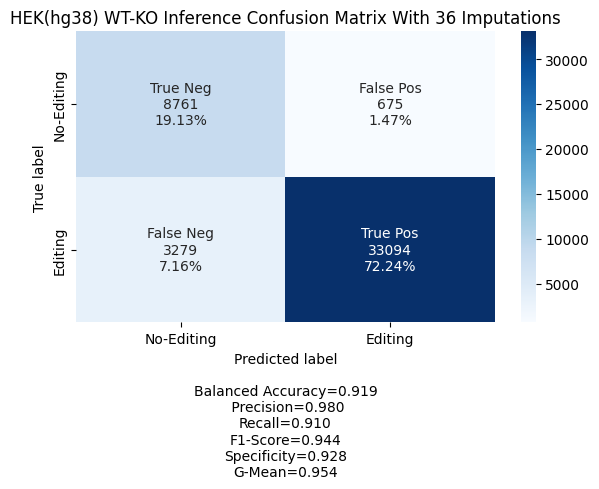

100%|██████████| 3/3 [00:09<00:00,  3.31s/it]


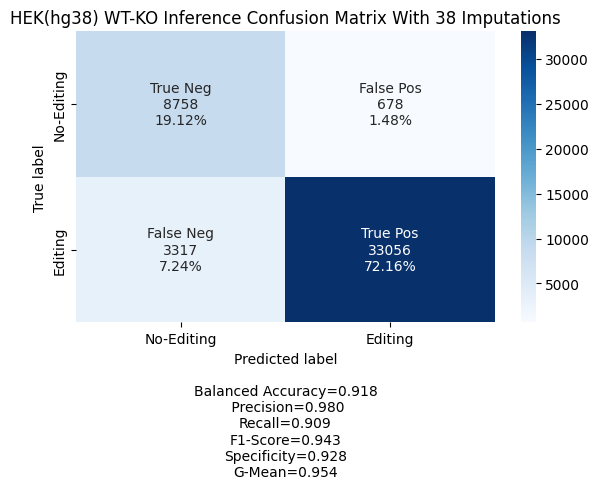

100%|██████████| 3/3 [00:10<00:00,  3.38s/it]


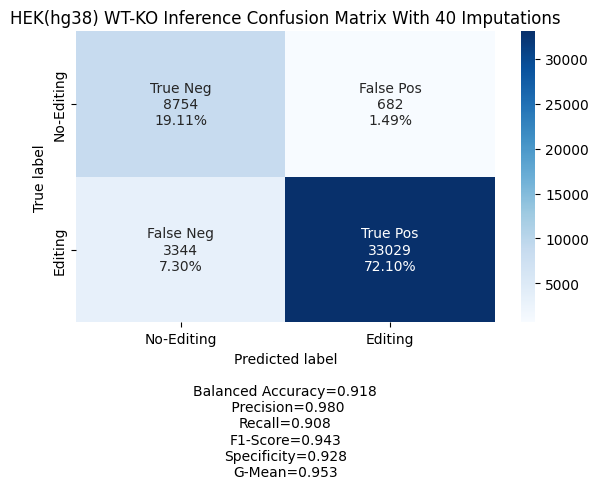

100%|██████████| 3/3 [00:10<00:00,  3.41s/it]


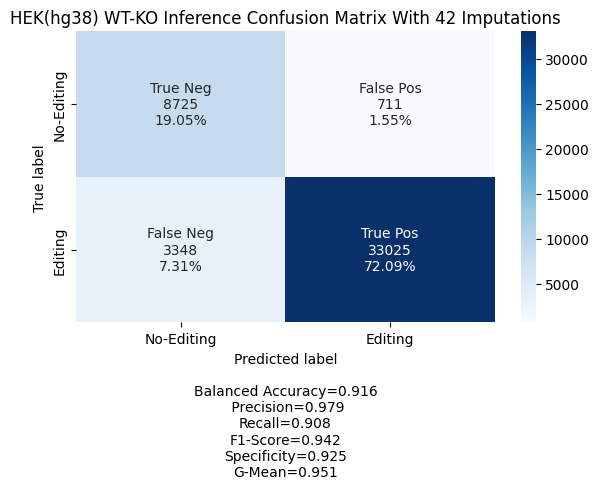

100%|██████████| 3/3 [00:10<00:00,  3.47s/it]


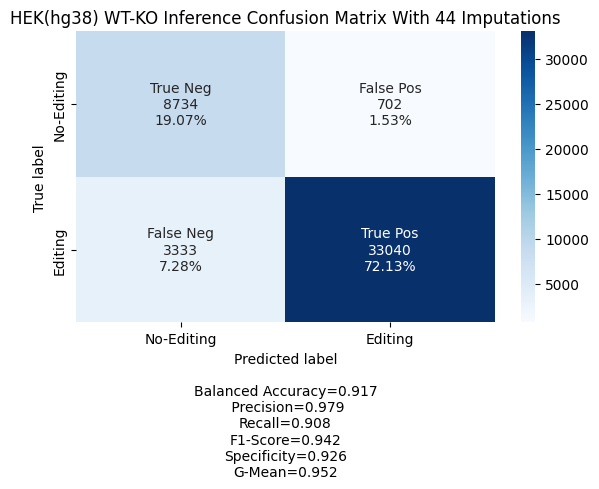

100%|██████████| 3/3 [00:10<00:00,  3.59s/it]


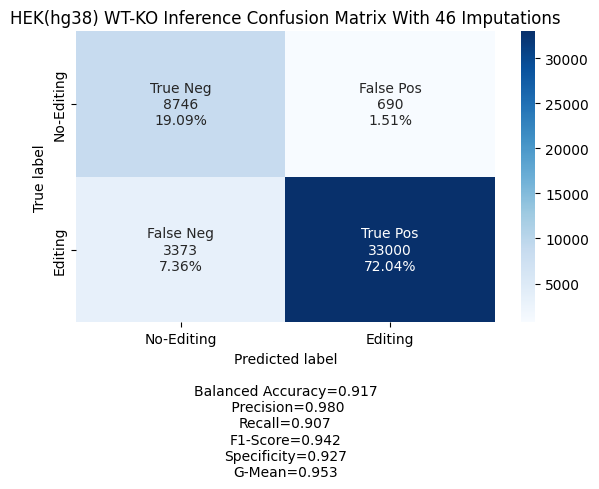

100%|██████████| 3/3 [00:10<00:00,  3.58s/it]


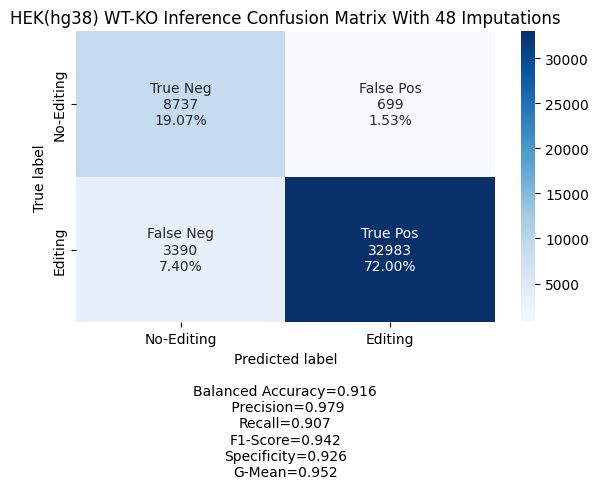

100%|██████████| 3/3 [00:10<00:00,  3.59s/it]


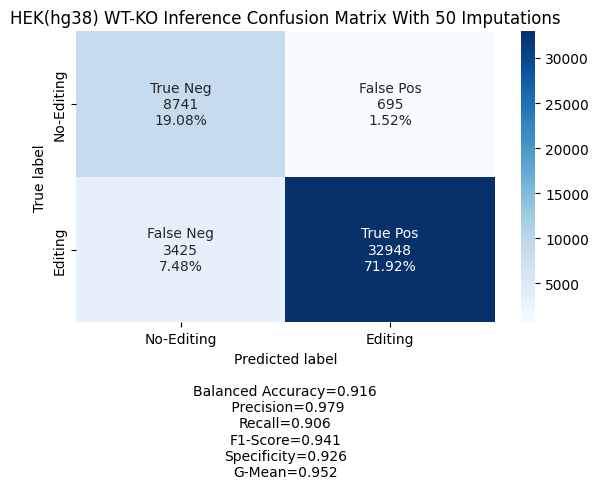

100%|██████████| 3/3 [00:10<00:00,  3.64s/it]


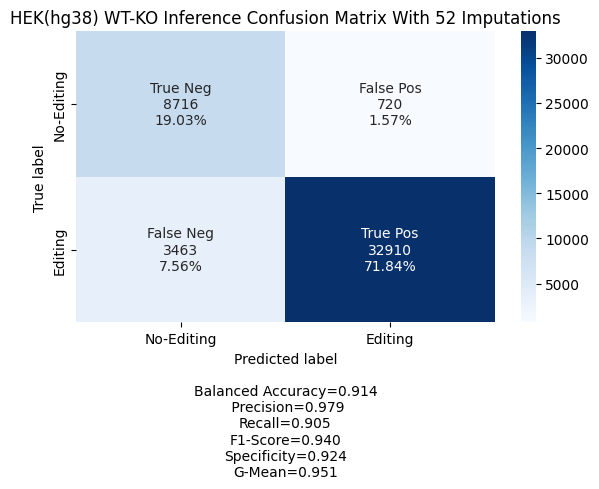

100%|██████████| 3/3 [00:11<00:00,  3.77s/it]


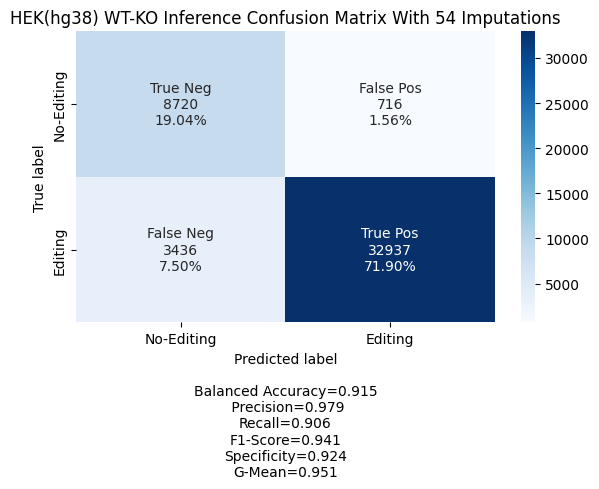

100%|██████████| 3/3 [00:11<00:00,  3.79s/it]


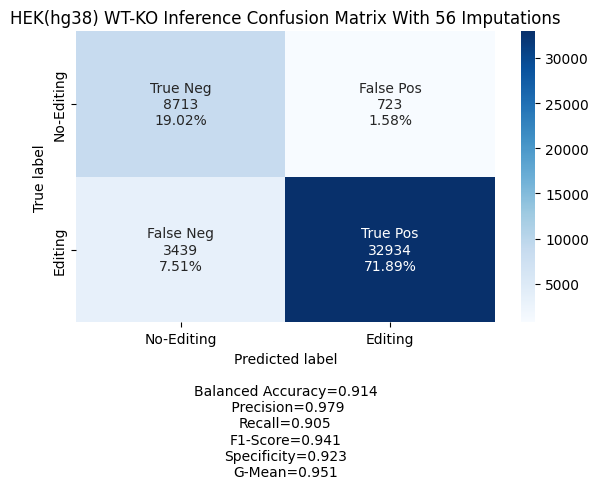

100%|██████████| 3/3 [00:11<00:00,  3.83s/it]


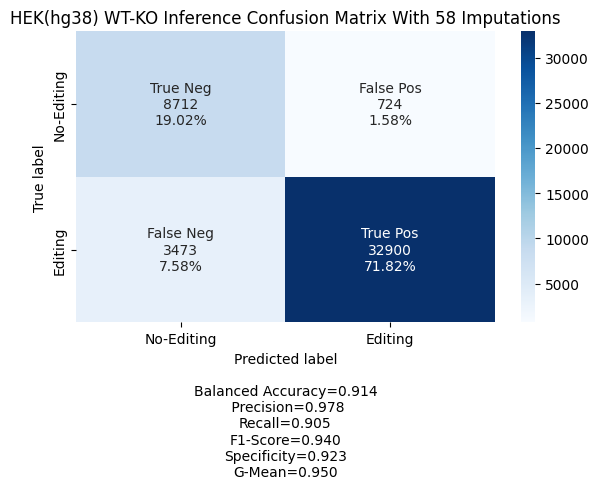

100%|██████████| 3/3 [00:11<00:00,  3.93s/it]


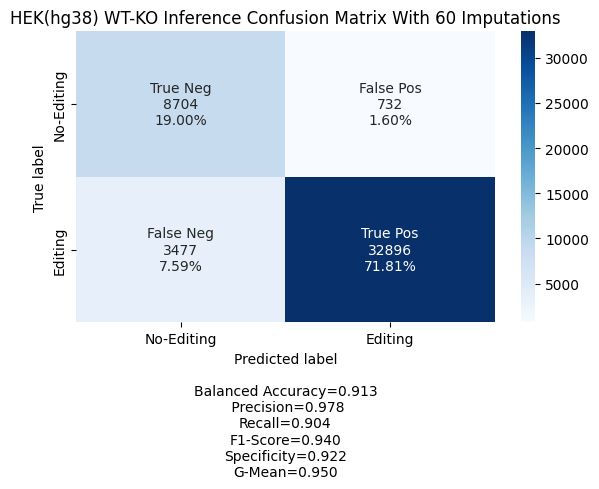

100%|██████████| 3/3 [00:11<00:00,  3.95s/it]


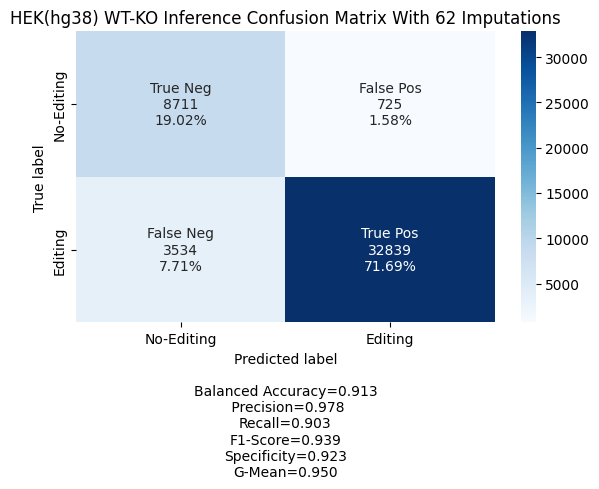

100%|██████████| 3/3 [00:11<00:00,  3.99s/it]


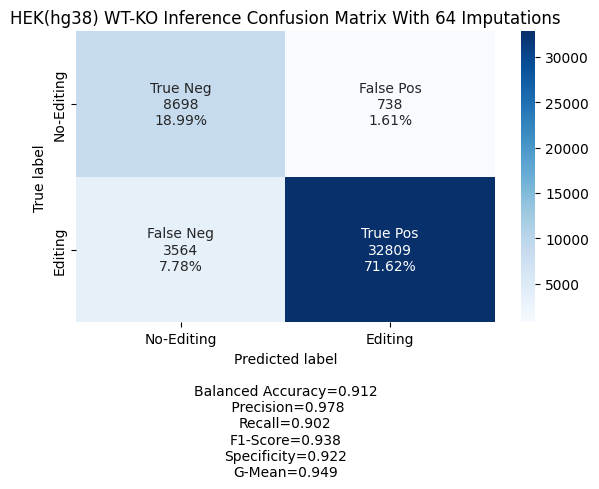

100%|██████████| 3/3 [00:12<00:00,  4.06s/it]


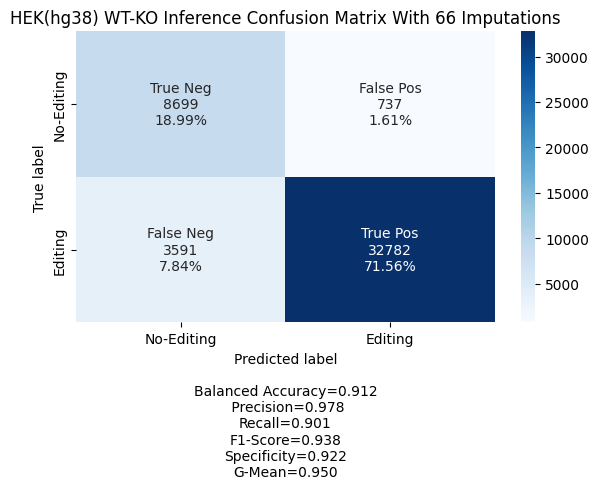

100%|██████████| 3/3 [00:11<00:00,  3.94s/it]


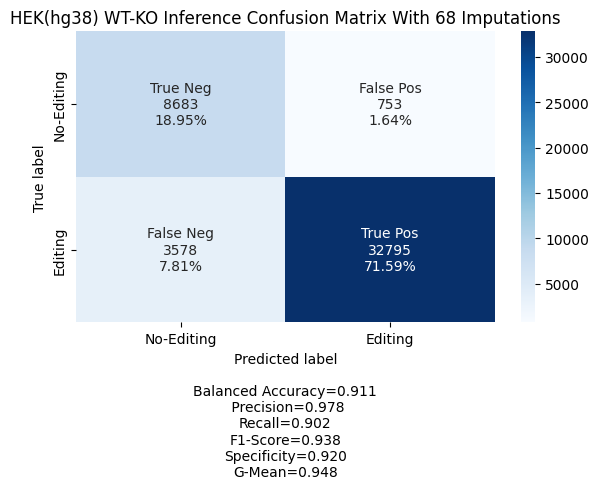

100%|██████████| 3/3 [00:12<00:00,  4.02s/it]


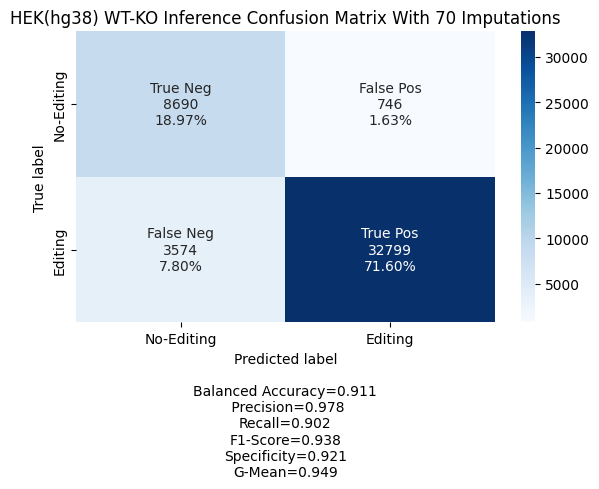

100%|██████████| 3/3 [00:12<00:00,  4.10s/it]


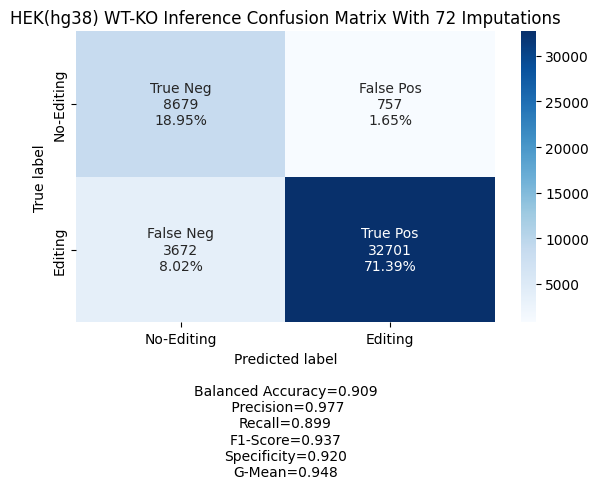

100%|██████████| 3/3 [00:12<00:00,  4.24s/it]


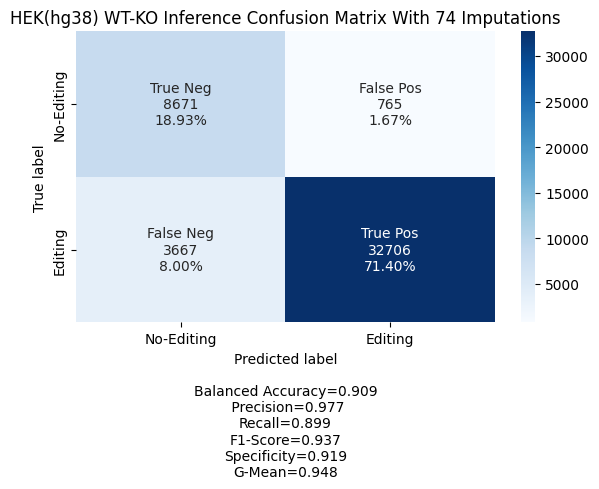

100%|██████████| 3/3 [00:12<00:00,  4.24s/it]


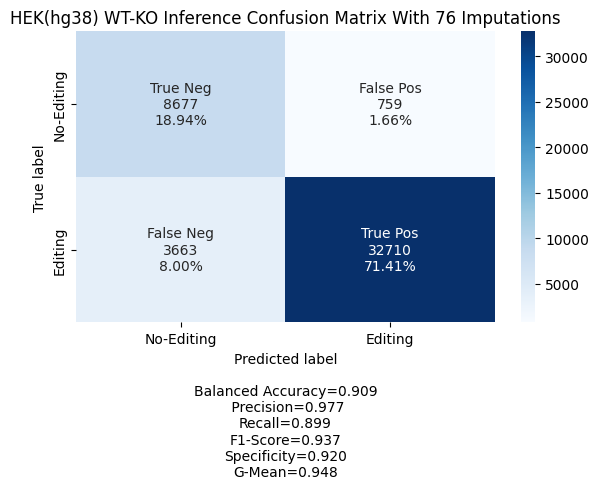

100%|██████████| 3/3 [00:13<00:00,  4.34s/it]


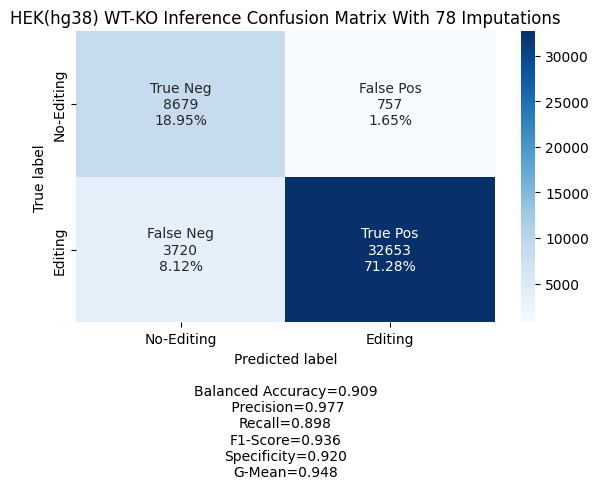

100%|██████████| 3/3 [00:13<00:00,  4.38s/it]


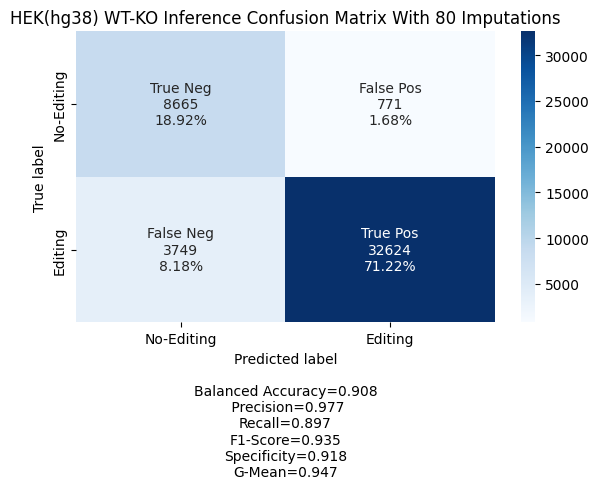

100%|██████████| 3/3 [00:13<00:00,  4.45s/it]


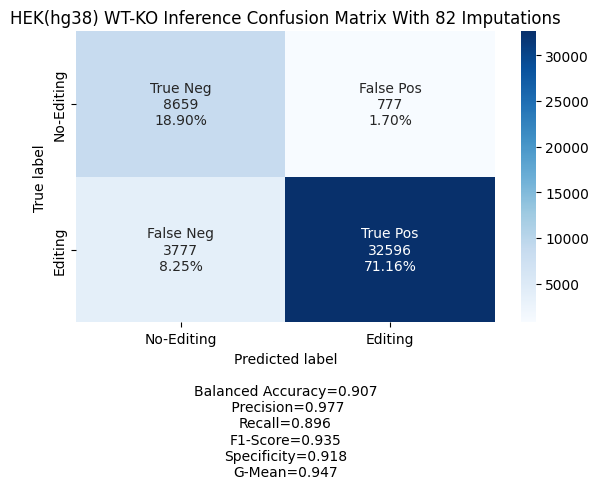

100%|██████████| 3/3 [00:13<00:00,  4.43s/it]


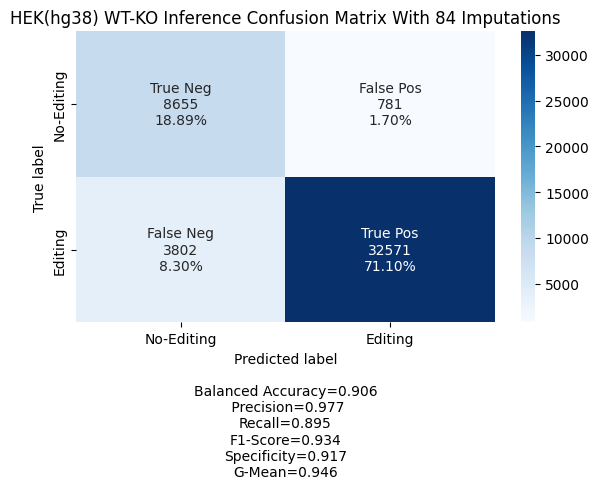

100%|██████████| 3/3 [00:13<00:00,  4.43s/it]


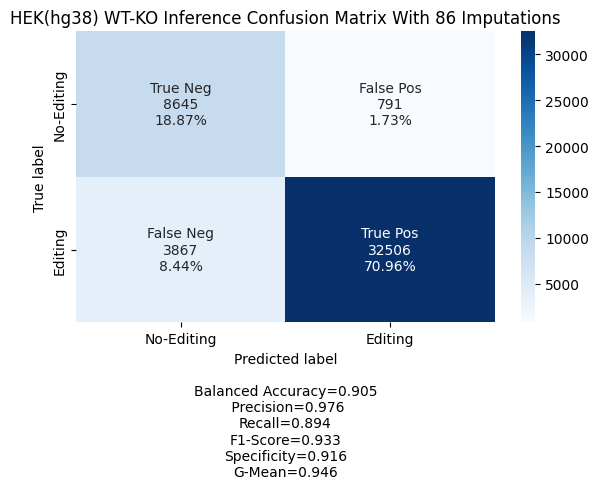

100%|██████████| 3/3 [00:13<00:00,  4.50s/it]


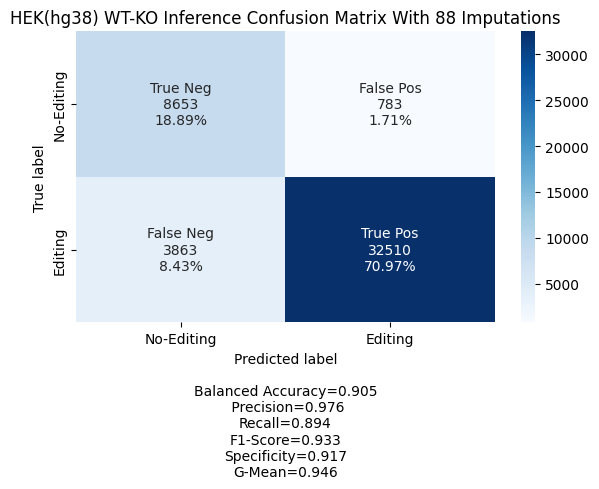

100%|██████████| 3/3 [00:14<00:00,  4.77s/it]


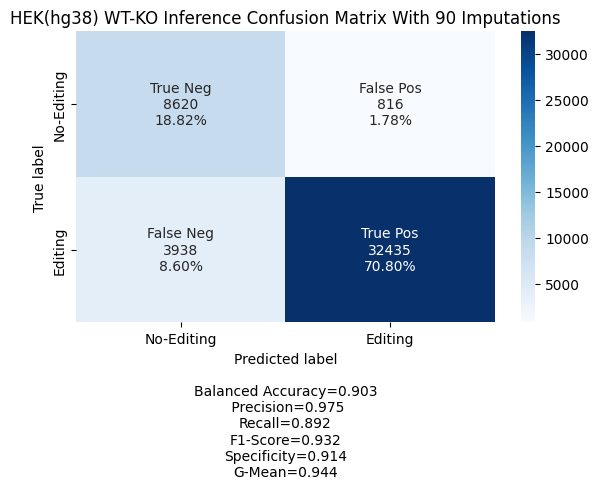

100%|██████████| 3/3 [00:14<00:00,  4.67s/it]


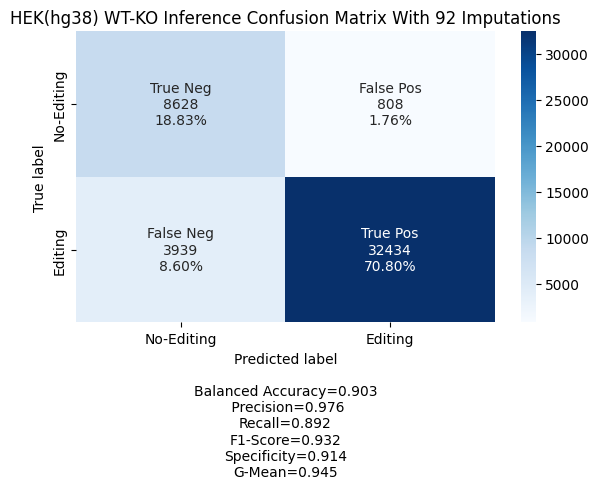

100%|██████████| 3/3 [00:14<00:00,  4.70s/it]


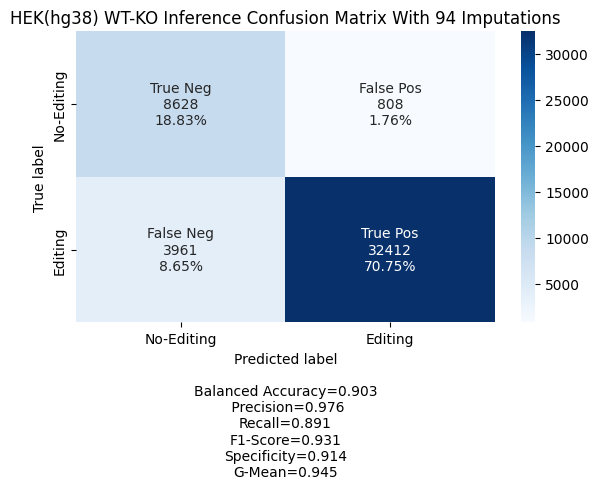

100%|██████████| 3/3 [00:14<00:00,  4.79s/it]


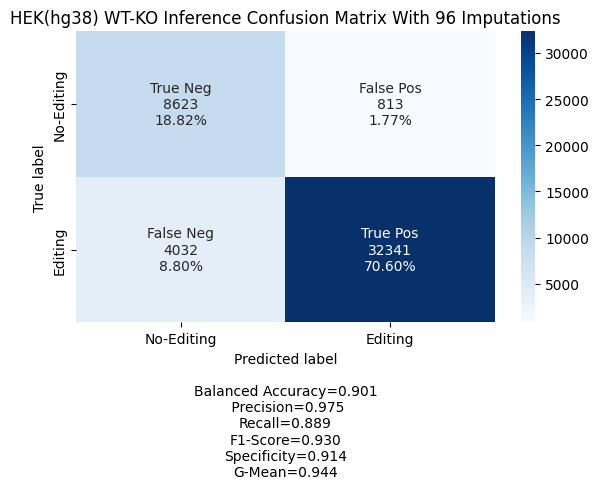

100%|██████████| 3/3 [00:14<00:00,  4.81s/it]


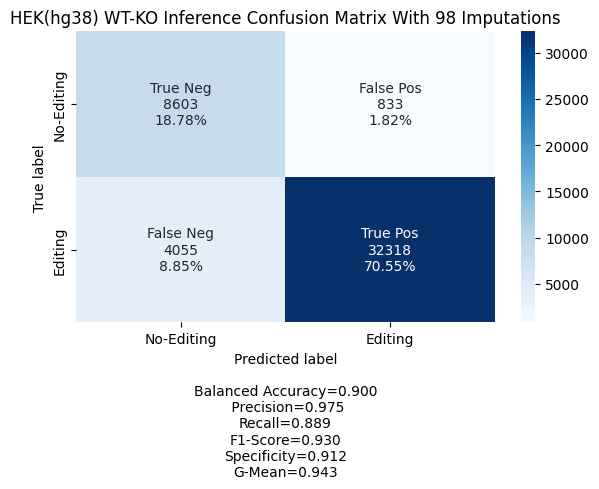

100%|██████████| 3/3 [00:14<00:00,  4.87s/it]


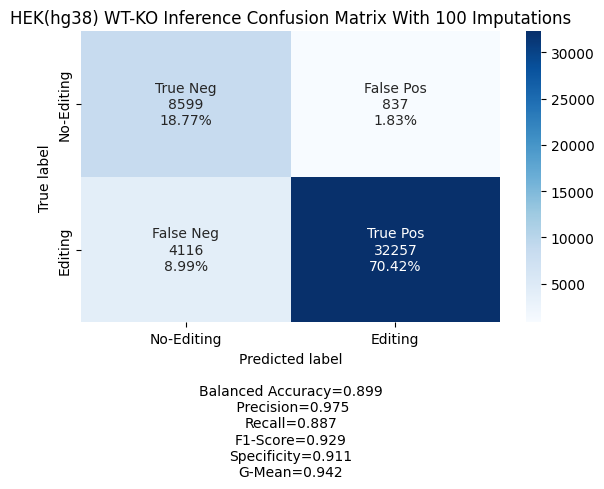

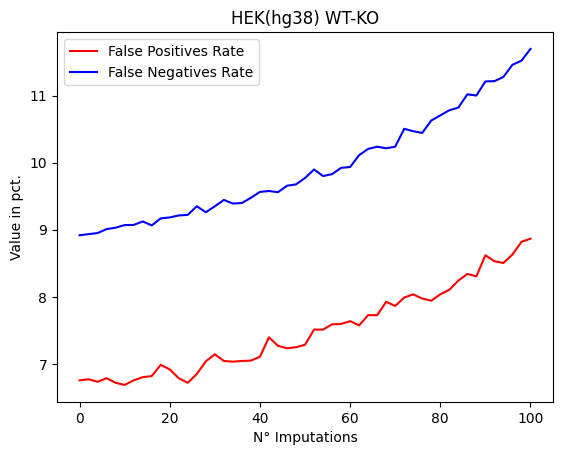

In [4]:
model_filepath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/REDInet_models/REDInet_log_preprocessing_pos_zeros_snps_29_02_2024_22_25_45.h5"

cells = "HEK293T"

df, path = make_imputations(cells, model_filepath)

x = df.loc[:, "N_Imputations"].tolist()               
df.loc[:, "False Positives Rate"] = 100*(df.loc[:,"FP"]/(df.loc[:,"FP"]+df.loc[:, "TN"]))
df.loc[:, "False Negatives Rate"] = 100*(df.loc[:,"FN"]/(df.loc[:,"FN"]+df.loc[:, "TP"]))

fpr = df.loc[:, "False Positives Rate"].tolist()
fnr = df.loc[:, "False Negatives Rate"].tolist()
                 
                 
plt.plot(x, fpr, label = "False Positives Rate", color="red") 
plt.plot(x, fnr, label = "False Negatives Rate", color="blue") 
plt.xlabel('N° Imputations') 
plt.ylabel('Value in pct.') 
plt.title('HEK(hg38) WT-KO') 
plt.legend() 
plt.savefig(f"{path}/{cells}_Imputations_False_Positives_Rate_False_Negatives_Rate_plot.tiff", dpi=300, 
            bbox_inches='tight', facecolor='white', transparent=False) 
plt.show()